### 2 - Sentiment Analysis of the First 3 Weeks 


Love Island has [often been criticized](https://www.cosmopolitan.com/uk/entertainment/a26846803/mike-thalassitiss-death-reaction-love-island-twitter/) for not looking after the mental health of contestants; with two previous contestants having committed suicide and the there have been for [calls to pull the show](https://www.thesun.co.uk/tvandshowbiz/8705713/love-island-mike-thalassitis-sophie-gradon-suicide-reality-tv/), the fact that the Jeremy Kyle show was canceled due to [the death of a participant](https://www.wired.co.uk/article/jeremy-kyle-show-mental-illness) a few weeks prior to Love Island being aired added a lot of fuel to the fire. In response, prior to announcing this season, the producers of the show and ITV placed a [large emphasis](https://www.itv.com/presscentre/press-releases/itv-outlines-duty-care-processes-ahead-series-5-itv2s-love-island) focusing on the "aftercare" of cast members, with this change being one of the [largest to this series](https://www.gq-magazine.co.uk/article/love-island-mental-health); whilst there has been a lot of [cynicism about this online](https://graziadaily.co.uk/life/tv-and-film/love-island-aftersun-ovie/), this has generally been received well by the public. According to both ex-islanders and mental health professionals, one of the main sources of pressure for islanders when they leave the villa is [social media and constantly hearing negative messages from the public about themselves](https://www.radiotimes.com/news/tv/2019-05-15/reality-tv-mental-health-love-island-big-brother/). 

In this notebook I aim to investigate the sentiment behind tweets that reference love island, specifically tweets that explicitly mention the individual contestants to determine both the scale of the problem and to observe if we can see reactions to events during the show playing out in the twitter data. 

Before finding the sentiment of each tweet the raw text need to be cleaned, the literature however is very inconsistent with how "heavy-handed" one should be when putting together a pipeline for cleaning text, especially twitter data. On the one hand [authors suggest](https://pdfs.semanticscholar.org/6969/5bc9dcb5da81e305af8bf85ab5ca4d6619a9.pdf) that leaving tweets alone is the correct way to do it, with nuances in language and placement of capital letters etc being some of the features of raw data that should be being picked up by the analysis. [Other authors](http://ceur-ws.org/Vol-1748/paper-06.pdf) suggest that reducing the tweets down to only keep the fundamental parts, for example, removing stop words, normalizing case and generally trying to only feed the algorithms the really crucial parts of the text is the correct approach. For this piece my preprocessing will have a number of rules, this is mainly to try and reduce noise in the data and given we have such a large corpus and the "none typical" nature of the topics that are to be discussed, one would expect the standard text cleaning algorithms to produce good results, the steps I am going to follow are:
- Normalize case (making all text lower case)
- Remove punctuation 
- Strip all leading and trailing whitespace 
- Remove numbers 
- Remove non-ASCII characters (this is just precautionary as twitter shouldn't allow ASCII characters)
- Remove all references to "love island" ("love" is a very heavily weighted word in terms of sentiment analysis and for a tweet to be included in our data we know that it will include the "#loveisland", therefore it is imperative that this is removed) 
- Remove stop words (words such as "and", "then" etc; they don't add anything in terms of sentiment to the tweet)
- Lemmatize each word (this makes the word usage in the whole corpus more consistent, lemmatizing effectively shortens words to their root, so "making" would be transformed to "make", "kissed" to "kiss" etc)
- Remove words that are shorter than 3 characters (at this point given the heavy natured approach of the above steps words with 2 or fewer characters will just be errors or not important) 
The bulk of this preprocessing is done is via base python and the excellent [spaCy](https://spacy.io/) package. 

In terms of the full "end to end pipeline" of going from raw text data to presenting analysis, I am going to "borrow" the pipeline steps set out in [Wang et al's paper that analyses tweets on the US presidential election](https://www.aclweb.org/anthology/P12-3020), however mine will be it in a slightly different order. Firstly I will match islanders to each tweet, preprocess the text as per the above steps, find the sentiment of each tweet and then aggregate and visualize. To find the sentiment of each tweet I am going to use the compound score produced by running each tweet through the `SentimentIntensityAnalyzer` class from the [NLTK](https://www.nltk.org/) package, no initial validation has been done to check that this method is applicable to this corpus but we shall validate as we go along. 

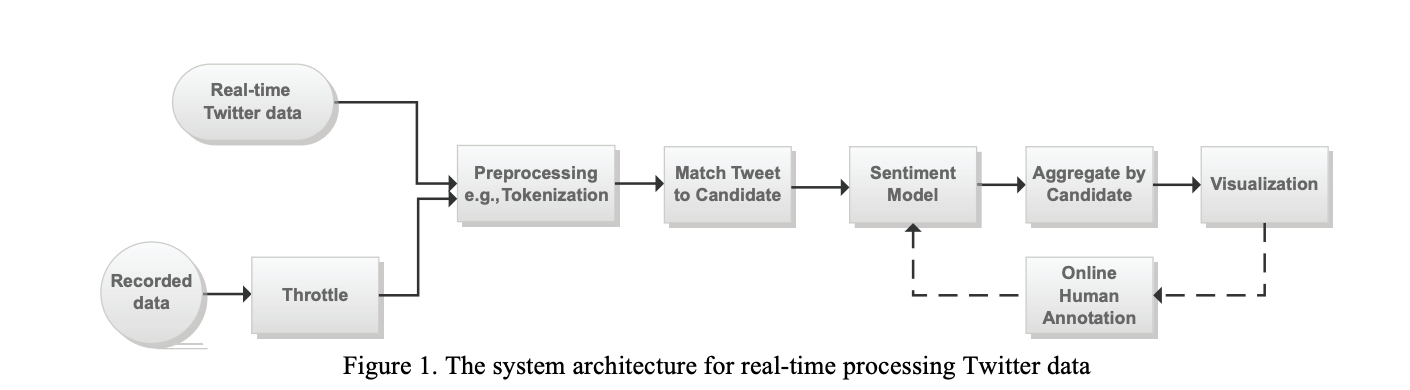

https://www.aclweb.org/anthology/P12-3020


In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt 

from loveisland.common.constants import ISLANDERS
from loveisland.common.functions import import_all, get_islanders, get_palette, get_islander_df, str_to_list

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use("bmh")

In [2]:
PALETTE = get_palette()
ORIGINAL_ISLANDERS = get_islanders()

islander_df = get_islander_df()
RELEVANT_ISLANDERS = islander_df[islander_df["arrived"] <= 21]["islander"]

In [27]:
def islander_agg(df, islander):
    """Aggregate various metrics per islander/date"""
    AGG_JS = {
        "favs": "mean",
        "retwe": "mean",
        "score": "mean",
        "user": "nunique",
        "url": "count",
        "weight_senti": "mean",
    }
    RN_JS = {islander: "islander", "url": "n_tweets", "user": "n_users"}
    df = df[df[islander] == islander]
    df = df[df["score"] != 0]
    if len(df) > 0:
        return df.groupby([islander, "date"])\
                 .agg(AGG_JS)\
                 .reset_index()\
                 .rename(columns=RN_JS)
    return pd.DataFrame()

def aggregate_all(df):
    """Loop over all islanders, aggregating metrics"""
    agg_df = pd.DataFrame()
    for islander in ISLANDERS:
        agg = islander_agg(df, islander)
        agg_df = agg_df.append(agg, sort=True)
    return agg_df.reset_index(drop=True)

def dt_filters(df):
    return df[(df["date"] >= "2019-06-03") & (df["date"] < "2019-06-24")]

def inc_islander(df, col="islanders"):
    df[col] = df[col].apply(lambda x: str_to_list(x))
    df["inc_islander"] = df[col].apply(lambda x: len(x))
    df["inc_islander"] = np.where(df["inc_islander"] < 1, "No", "Yes")
    return df

def add_cols(df, islander_df):
    df["total_favs"] = df["favs"] * df["n_tweets"]
    df["total_retwe"] = df["retwe"] * df["n_tweets"]
    df = df.merge(islander_df, on="islander", how="left")
    df["n_days"] = np.where(df["dumped"] != 0, df["dumped"] - df["arrived"], 21)
    return df

def format_xticks(df, ax, n=1, col="date", rotate=True):
    x_dates = df["date"].dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.xaxis.set_major_formatter(plt.FixedFormatter(x_dates))

    if rotate:
        plt.xticks(rotation=20, ha="right")
    
    xticks = ax.xaxis.get_major_ticks()
    for i in range(len(xticks)):
        if i % n != 0:
            xticks[i].set_visible(False);

def add_meta(ax, y, title, legend=True, x="Date"):
    if legend:
        ax.legend(bbox_to_anchor=(1, -0.2), ncol=11)
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    
def add_colours(ax, storyline):
    for key, item in storyline.items():
        ax.axvline(item["date"], color=item["color"], linewidth=item["t"], alpha=0.2)
        
def get_counts(df, group):
    return df.groupby(group)["url"].count().reset_index(name="count")

In [41]:
df = import_all()
df = dt_filters(df)
df = inc_islander(df)

agg_df = aggregate_all(df)

agg_df = agg_df[
    (agg_df["n_tweets"] >= 100) & (agg_df["islander"].isin(RELEVANT_ISLANDERS))
]
agg_df = add_cols(agg_df, islander_df)
agg_df.head()

,date,favs,islander,n_tweets,n_users,retwe,score,weight_senti,total_favs,total_retwe,col,sex,relevant,arrived,dumped,n_days
0,2019-06-03,23.082865,anton,5334,4386,2.704537,-0.105496,2.701545,123124.0,14426.0,#D7D5DC,male,True,1,0,21
1,2019-06-04,26.078431,anton,1275,1164,3.518431,-0.030283,3.480721,33250.0,4486.0,#D7D5DC,male,True,1,0,21
2,2019-06-05,10.465686,anton,612,569,0.857843,0.011411,2.236024,6405.0,525.0,#D7D5DC,male,True,1,0,21
3,2019-06-06,18.891785,anton,1765,1563,1.884986,0.087465,2.735412,33344.0,3327.0,#D7D5DC,male,True,1,0,21
4,2019-06-07,78.357143,anton,2170,1877,8.431797,0.180862,16.573537,170035.0,18297.0,#D7D5DC,male,True,1,0,21


For this notebook I am only going to focus on the first 3 weeks of the series, this includes all tweets sent between 3rd June 2019 (the day of the first episode airing) and 24th June 2019, during this time we have seen 7 islanders join the original 11 cast members and 4 islanders dumped (leave the show) over 2 "re-couplings". Notable events during the first few weeks of this series have included Joe and Lucie getting together, Sherif being mysteriously kicked out by producers, Maura entering the villa and making a play straight for Tommy and Danny's head "being turned" as Arabella enters the villa. 

In [42]:
storyline = {
    " Love Island \n Starts": {"date": "2019-06-03", "color": "Yellow", "h": 3, "t": 10},
    " Molly-Mae \n Enters": {"date": "2019-06-06", "color": "Green", "h": 2, "t": 3},
    " First Recoupling, \n Callum Dumped": {"date": "2019-06-07", "color": "Red", "h": 1, "t": 7},
    " Danny Enters": {"date": "2019-06-09", "color": "Green", "h": 2, "t": 3},
    " Sherif Kicked Out": {"date": "2019-06-11", "color": "Red", "h": 1, "t": 3},
    " Maura and Elma Enter": {"date": "2019-06-12", "color": "Green", "h": 2, "t": 3},
    " Second Recoupling, \n Tom and Jordan Enter": {"date": "2019-06-16", "color": "Green", "h": 2, "t": 7},
    " Joe and Elma \n are Dumped": {"date": "2019-06-18", "color": "Red", "h": 1, "t": 3},
    " Arabella Enters": {"date": "2019-06-20", "color": "Green", "h": 2, "t": 3},
}

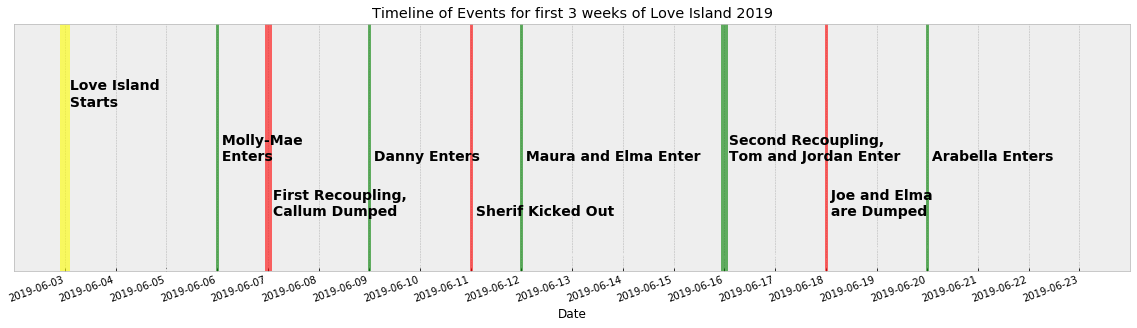

In [43]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(211)

sns.lineplot(x="date", y="score", color="#EEEEEE", data=agg_df[agg_df["islander"]=="anton"], ax=ax1)
plt.xticks(rotation=20, ha="right")
ax1.set(xticks=agg_df.date.unique(), yticks=[], xlabel="Date", ylabel="", ylim=(0, 3))
plt.title("Timeline of Events for first 3 weeks of Love Island 2019")

for key, item in storyline.items():
    ax1.axvline(item["date"], color=item["color"], linewidth=item["t"], alpha=0.6)
    ax1.text(item["date"], 2*item["h"]/3, key, fontsize=14, weight="bold")


### Initial Statistics 
Prior to looking at the sentiment data lets briefly go over some summary plots so we can see what the data we are dealing with looks like. Plotting the number of tweets per day we find that there is a lot of variance; there is an obvious peak on the first day and in fact even when removing this spike the first week is when most tweets were sent. The day with the 2nd most tweets was the 13th June, this coincides with the day after Maura entered the villa; given her actions in the first few days prompted [486 complaints to Ofcom (the British TV regulator](https://www.cosmopolitan.com/uk/entertainment/a28073036/ofcom-complaints-love-island-maura-joe/) this is not a surprise. The very notable troughs observed every 7 days all fall on Saturdays; the only day of the week Love Island is not on. In the first 3 weeks of Love Island, there were 1.08 million tweets that explicitly referenced the show; an average of over 51,000 a day. 

Total number of tweets in first 3 weeks of Love Island: 1080583
Mean number of tweets per day in first 3 weeks of Love Island: 51456.333333333336


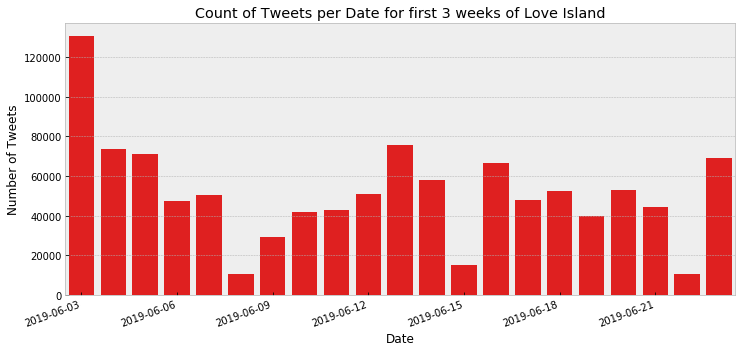

In [57]:
to_plot = get_counts(df, ["date"]) 

print("Total number of tweets in first 3 weeks of Love Island:", to_plot["count"].sum())
print("Mean number of tweets per day in first 3 weeks of Love Island:", to_plot["count"].mean())

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "count", data=to_plot, color="Red", ax=ax1)

format_xticks(to_plot, ax1, 3)
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.title("Count of Tweets per Date for first 3 weeks of Love Island");

Given our interest in the islanders themselves we can take a look at how many tweets reference at least one of the cast members; over the first 3 weeks an average of 55.9% of tweets a day specifically name at least one of the contestants. This summary statistic doesn't paint the full picture however, we see the percentage rising as we progress though the series as twitter users "get to know" the cast more and form favorites and grow to like / dislike couples more. Of the days the show is on, in the 3rd week we find that well over 60% of tweets contain a mention of one of the islanders, whilst they can't see their twitter at this moment in time (participants have no access to the outside world during their time on the show), when they leave the villa this sort of activity about them personally will be a huge change in their life. The day with the highest percentage of tweets specifically mentioning an islander was 16th June, this was the second "re-coupling" and the first time in the series there was a lot of drama peaking. 

Mean percentage of tweets per day in first 3 weeks of Love Island that reference an islander: 55.937905619736306


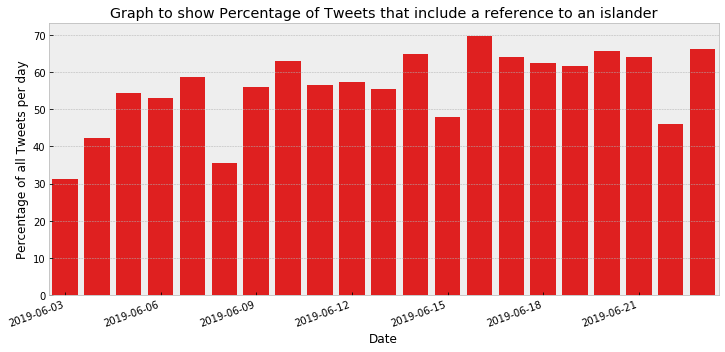

In [59]:
to_plot = get_counts(df, ["date", "inc_islander"]) 
to_plot["perc"] = to_plot.groupby("date")["count"].apply(lambda x: x*100 / x.sum())
to_plot = to_plot[to_plot["inc_islander"] == "Yes"]

print("Mean percentage of tweets per day in first 3 weeks of Love Island that reference an islander:", 
      to_plot["perc"].mean())

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "perc", data=to_plot, color="Red", ax=ax1)

format_xticks(to_plot, ax1, 3)
plt.title("Graph to show Percentage of Tweets that include a reference to an islander")
plt.xlabel("Date")
plt.ylabel("Percentage of all Tweets per day");

### Trending Sentiment Per Islander over time 

In order to assess if we can see the on-screen events in the corpus of tweets scraped, we can find the sentiment and aggregate per day all the tweets that mention by name an islander. The only filters we shall use are excluding days where we see less 100 tweets per islander (to reduce noise in the graphs) and including only tweets where the sentiment is not 0 again to reduce noise and given we want to observe reactions to events, not having a reaction and simply just referencing should be excluded!

Overlaying the "event bars" from the above plot will help us correlate to what is happening on twitter with what happened during the show. Whilst we are focusing on the sentiment score, it is important to consider the number of tweets about each islander, this might not only explain the sentiment score (if it an extreme value for example) but also will give us more insight into what is happening in terms of reaction to events. 

Firstly, concentrating on the plot of the female islanders, we see a number of interesting trends; looking at the pink line of Amy we see how she starts off as one of the most popular islanders in week one but as the series goes on she becomes one of the most unpopular. The opposite is true for Amber, who starts off the series as the least popular female but finishes as one of the most popular, Anna follows a similar pattern however tweets are initially slightly more positive about her, given their friendship it is not surprising that the publics reaction to them follows the same trajectory. 

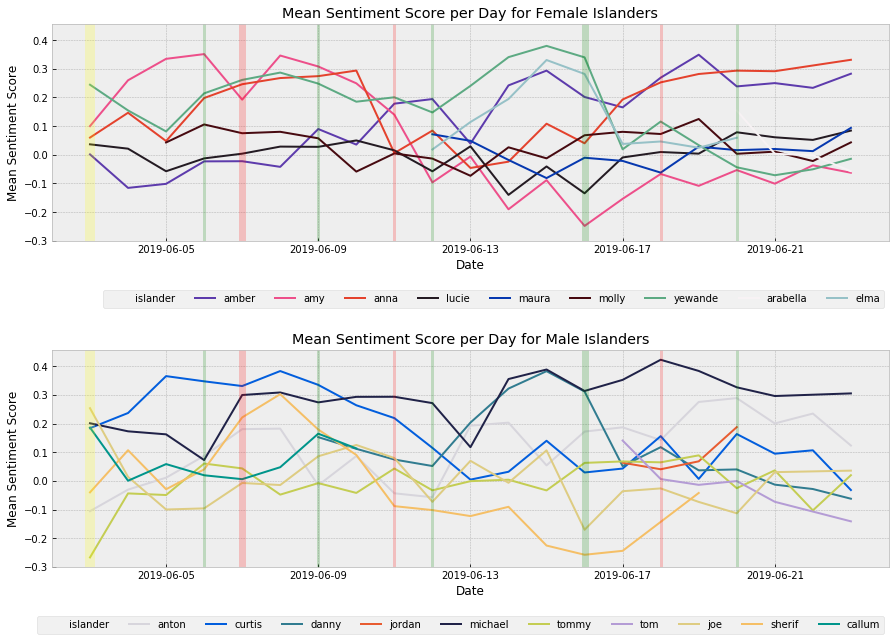

In [50]:
args = {"x": "date", "y": "score", "hue": "islander", "palette": PALETTE}
    
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(data=agg_df[agg_df["sex"]=="female"], ax=ax1, **args)
add_meta(ax1, "Mean Sentiment Score", "Mean Sentiment Score per Day for Female Islanders")
add_colours(ax1, storyline)

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
sns.lineplot(data=agg_df[agg_df["sex"]=="male"], ax=ax2, **args)
add_meta(ax2, "Mean Sentiment Score", "Mean Sentiment Score per Day for Male Islanders")
add_colours(ax2, storyline)

plt.subplots_adjust(hspace=0.5);

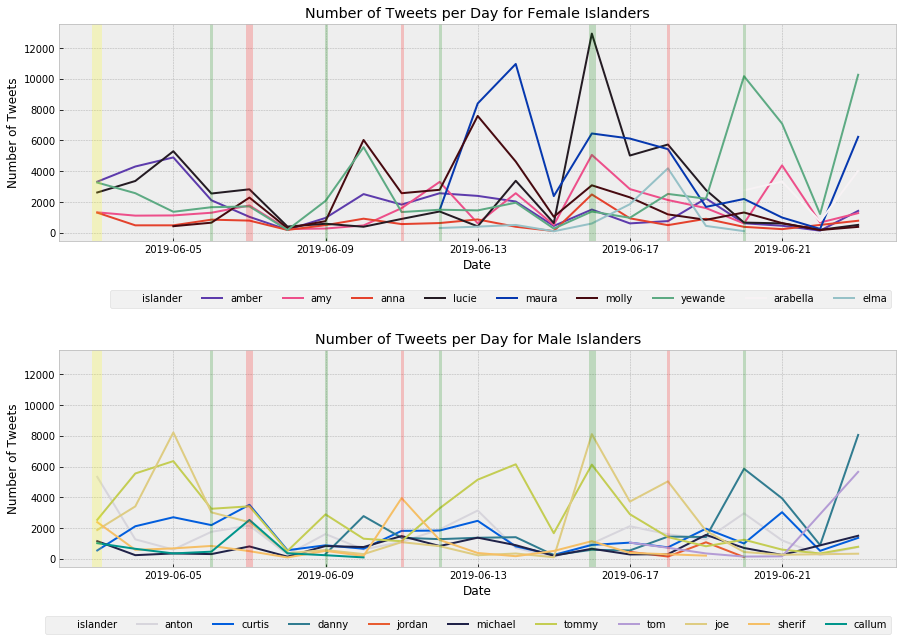

In [51]:
args = {"x": "date", "y": "n_tweets", "hue": "islander", "palette": PALETTE}
    
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
sns.lineplot(data=agg_df[agg_df["sex"]=="female"], ax=ax1, **args)
add_meta(ax1, "Number of Tweets", "Number of Tweets per Day for Female Islanders")
add_colours(ax1, storyline)

ax2 = fig.add_subplot(212, sharex=ax1, sharey=ax1)
sns.lineplot(data=agg_df[agg_df["sex"]=="male"], ax=ax2, **args)
add_meta(ax2, "Number of Tweets", "Number of Tweets per Day for Male Islanders")
add_colours(ax2, storyline)

plt.subplots_adjust(hspace=0.5);

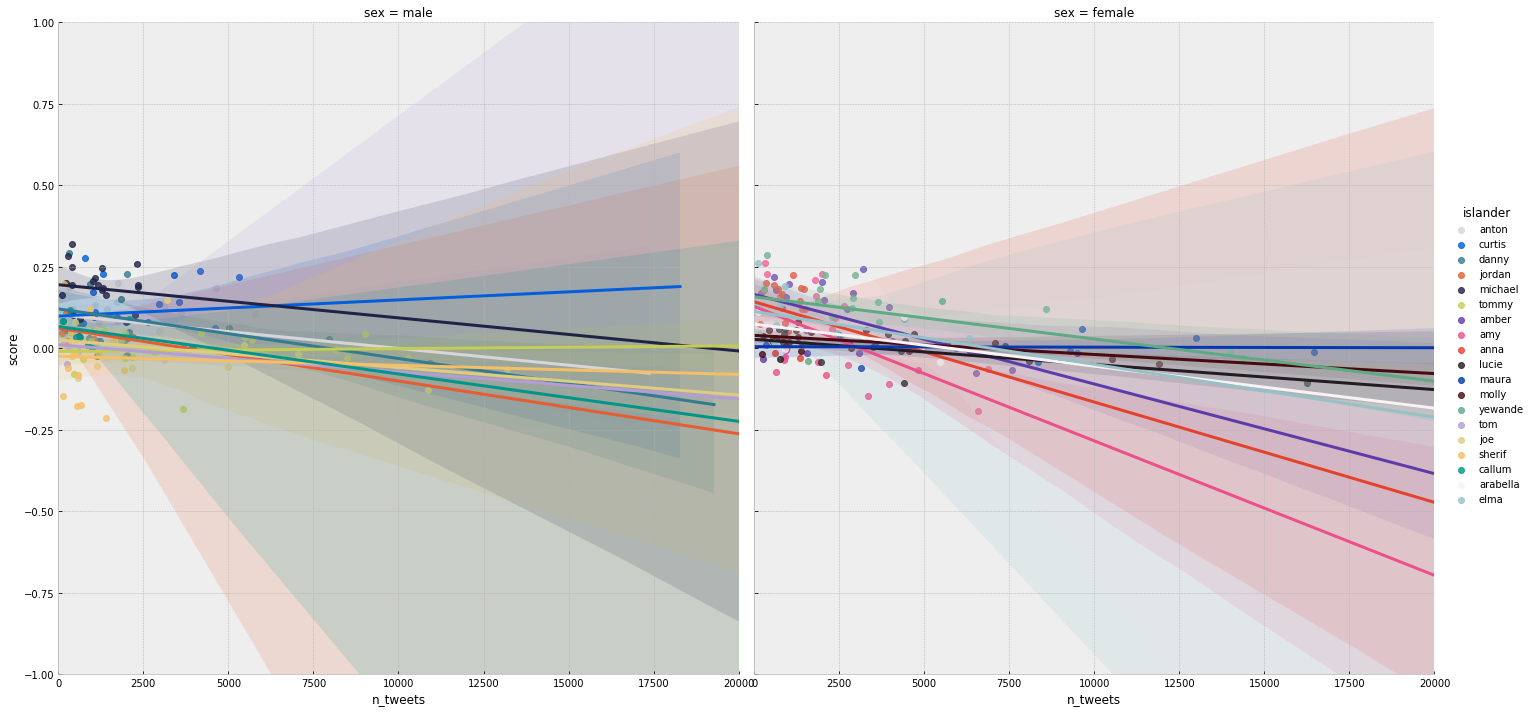

In [11]:
# Who is the most controversial?
# More tweets being correlated with a negative score = more convtroversial??

sns.lmplot("n_tweets", "score", hue="islander", data=agg_df, palette=PALETTE, height=10, col="sex")
plt.ylim(-1,1)
plt.xlim(0,20000);

In [12]:
def order_days(df, col="dotw"):
    df[col] = pd.Categorical(
                df[col],
                categories=[
                    "Monday",
                    "Tuesday",
                    "Wednesday",
                    "Thursday",
                    "Friday",
                    "Saturday",
                    "Sunday",
                ],
                ordered=True,
            )
    return df

def get_daily_counts(df, col="date"):
    df = get_counts(df, [col])
    df["dotw"] = df[col].dt.strftime("%A")
    return order_days(df)

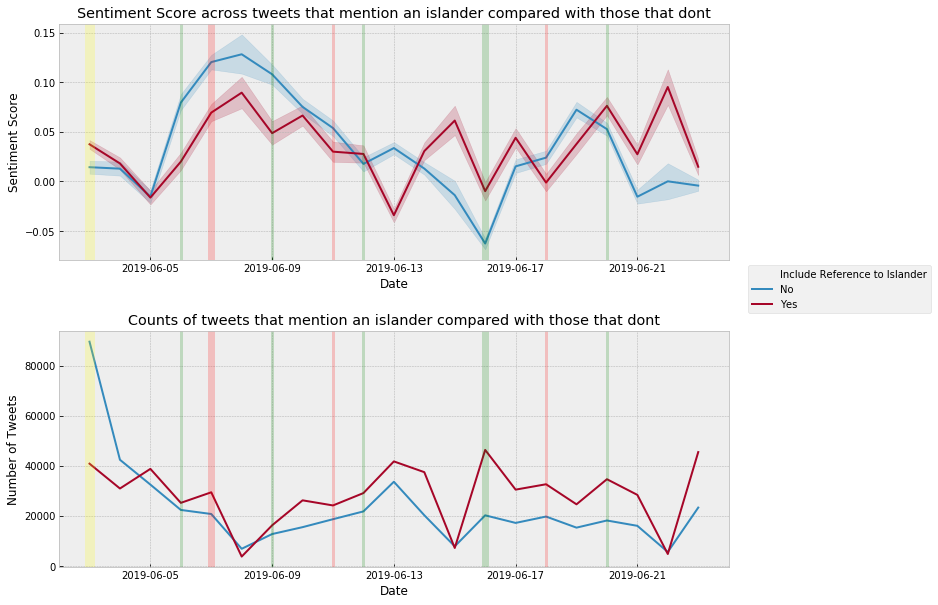

In [49]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(211)
sns.lineplot("date", "score", "inc_islander", data=df[df["score"] != 0], ax=ax1)
plt.legend().remove()
add_meta(
    ax1,
    "Sentiment Score",
    "Sentiment Score across tweets that mention an islander compared with those that dont",
    False,
)
add_colours(ax1, storyline)

to_plot = get_counts(df, ["date", "inc_islander"]).rename(
    columns={"inc_islander": "Include Reference to Islander"}
)
ax2 = fig.add_subplot(212, sharex=ax1)
sns.lineplot("date", "count", "Include Reference to Islander", data=to_plot, ax=ax2)
add_meta(
    ax2,
    "Number of Tweets",
    "Counts of tweets that mention an islander compared with those that dont",
    False,
)
plt.legend(bbox_to_anchor=(1.31, 1.3))
add_colours(ax2, storyline)

plt.subplots_adjust(hspace=0.3)

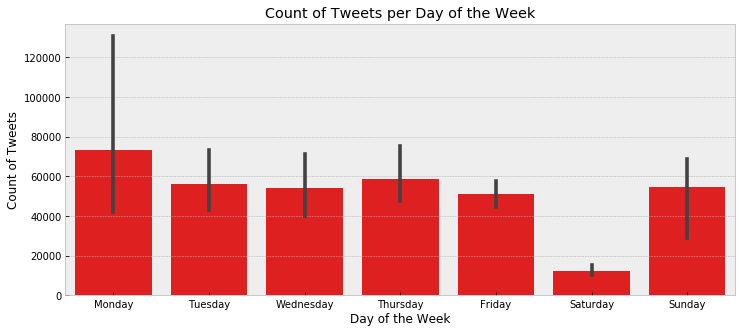

In [13]:
to_plot = get_daily_counts(df) 

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("dotw", "count", data=to_plot, color="Red", ax=ax1)

plt.xlabel("Day of the Week")
plt.ylabel("Count of Tweets")
plt.title("Count of Tweets per Day of the Week");

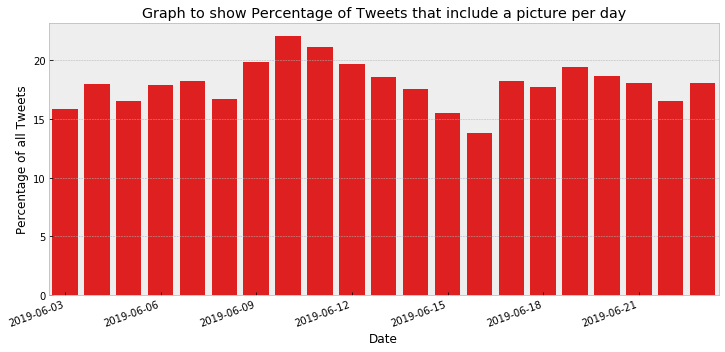

In [15]:
to_plot = get_counts(df, ["date", "pic"]) 
to_plot["perc"] = to_plot.groupby("date")["count"].apply(lambda x: x*100 / x.sum())
to_plot = to_plot[to_plot["pic"] == "yes"]

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("date", "perc", data=to_plot, color="Red", ax=ax1)

format_xticks(to_plot, ax1, 3)
plt.title("Graph to show Percentage of Tweets that include a picture per day")
plt.xlabel("Date")
plt.ylabel("Percentage of all Tweets");

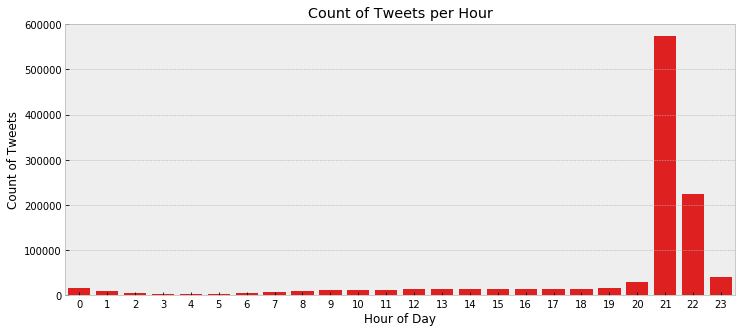

In [16]:
to_plot = get_counts(df, ["hour"]) 

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(111)
sns.barplot("hour", "count", data=to_plot, color="Red", ax=ax1)

plt.xlabel("Hour of Day")
plt.ylabel("Count of Tweets")
plt.title("Count of Tweets per Hour");

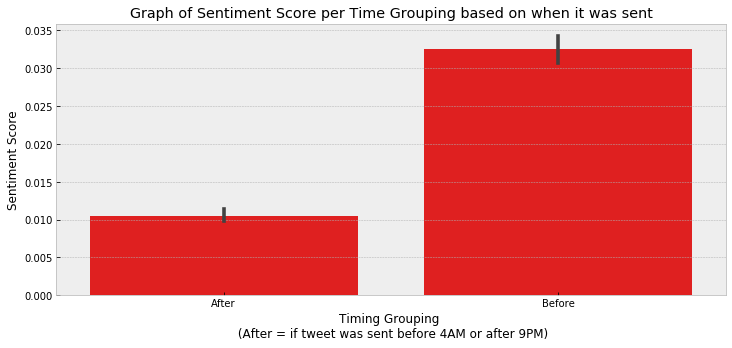

In [17]:
def group_hour(df, col="hour"):
    df["time_group"] = np.where((df[col] < 4) | (df[col] >= 21), "After", "Before")
    return df

df = group_hour(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("time_group", "score", data=df, color="Red", ax=ax1)

plt.xlabel("Timing Grouping \n (After = if tweet was sent before 4AM or after 9PM)")
plt.ylabel("Sentiment Score")
plt.title("Graph of Sentiment Score per Time Grouping based on when it was sent");

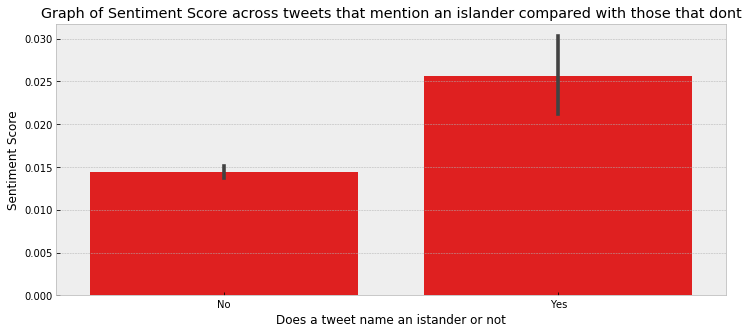

In [18]:
def inc_islander(df, col="islanders"):
    df["inc_islander"] = np.where(df[col].str.len() < 3, "No", "Yes")
    return df

df = inc_islander(df)

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)

sns.barplot("inc_islander", "score", data=df, color="Red", ax=ax1)

plt.xlabel("Does a tweet name an istander or not")
plt.ylabel("Sentiment Score")
plt.title("Graph of Sentiment Score across tweets that mention an islander compared with those that dont");

In [19]:
def islander_agg_user(df, islander):
    """Aggregate various metrics per islander/date"""
    AGG_JS = {
        "favs": "sum",
        "retwe": "sum",
        "score": "mean",
        "url": "count",
        "weight_senti": "mean",
    }
    RN_JS = {islander: "islander", "url": "n_tweets"}
    df = df[df[islander] == islander]
    if len(df) > 0:
        return df.groupby(["user", islander])\
                 .agg(AGG_JS)\
                 .reset_index()\
                 .rename(columns=RN_JS)
    return pd.DataFrame()

def aggregate_users(df):
    """Loop over all islanders, aggregating metrics"""
    agg_df = pd.DataFrame()
    for islander in ISLANDERS:
        agg = islander_agg_user(df, islander)
        agg_df = agg_df.append(agg, sort=True)
    return agg_df.sort_values(by="n_tweets", ascending=False)\
                 .reset_index(drop=True)

In [20]:
fav_df = aggregate_users(df)
fav_df = add_cols(fav_df, islander_df)
fav_df = fav_df[fav_df["islander"].isin(RELEVANT_ISLANDERS)]
fav_df.head()

,favs,islander,n_tweets,retwe,score,user,weight_senti,total_favs,total_retwe,col,sex,relevant,arrived,dumped,n_days
0,448,tommy,265,67,-0.514483,Daily_Star,-0.712573,118720,17755,#C4CD53,male,True,1,0,21
1,381,maura,214,60,-0.253803,Daily_Star,-0.389365,81534,12840,#0638AF,female,True,10,0,21
2,458,tommy,214,86,-0.662160,Daily_Express,-1.351415,98012,18404,#C4CD53,male,True,1,0,21
3,500,maura,201,134,-0.110108,MirrorTV,-0.074462,100500,26934,#0638AF,female,True,10,0,21
4,379,tommy,197,129,-0.157954,MirrorTV,-0.225895,74663,25413,#C4CD53,male,True,1,0,21


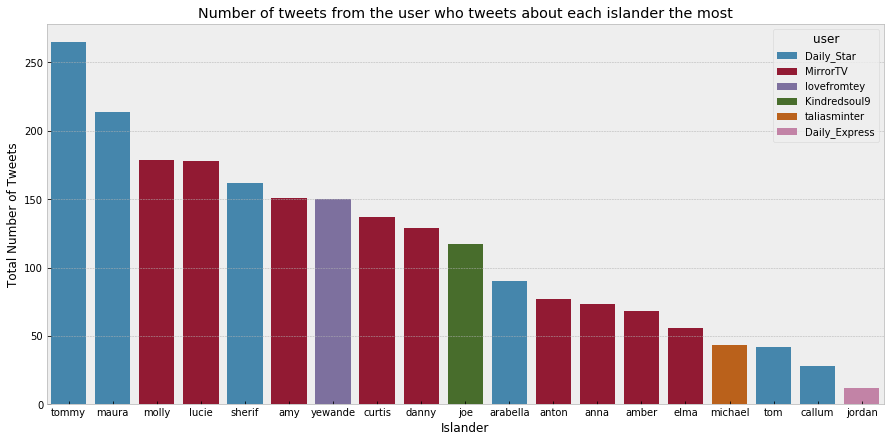

In [21]:
fav_df_pop = fav_df.sort_values(by="n_tweets", ascending=False).groupby(["islander"]).head(1)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(111)

sns.barplot("islander", "n_tweets", "user", data=fav_df_pop, dodge=False, ax=ax1)

plt.xlabel("Islander")
plt.ylabel("Total Number of Tweets")
plt.title("Number of tweets from the user who tweets about each islander the most");

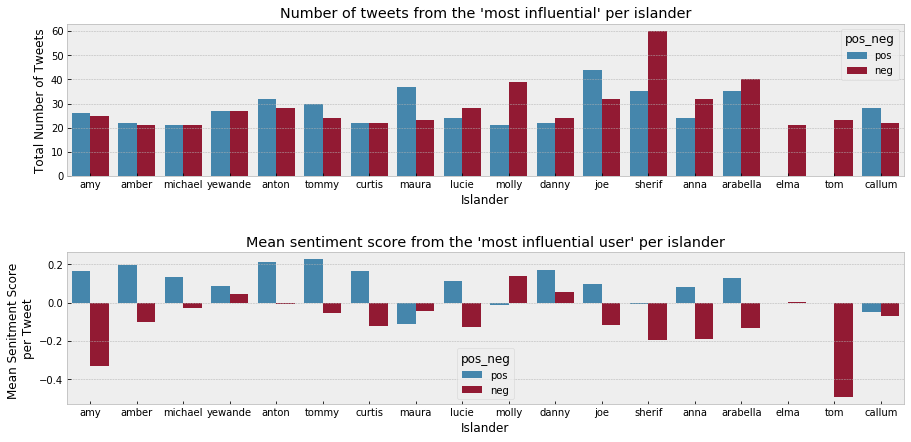

In [22]:
fav_df_pop = fav_df.copy()
fav_df_pop = fav_df_pop[fav_df_pop["n_tweets"] > 20]
fav_df_pop["pos_neg"] = np.where(fav_df_pop["weight_senti"] < 0, "neg", "pos")
fav_df_pop["weight_senti"] = abs(fav_df_pop["weight_senti"])
fav_df_pop = fav_df_pop.sort_values(by="weight_senti", ascending=False).groupby(["islander", "pos_neg"]).head(1)

fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(211)
sns.barplot("islander", "n_tweets", "pos_neg", data=fav_df_pop, dodge=True, ax=ax1)
ax1.set_xlabel("Islander")
ax1.set_ylabel("Total Number of Tweets")
ax1.set_title("Number of tweets from the 'most influential' per islander")

ax2 = fig.add_subplot(212)
sns.barplot("islander", "score", "pos_neg", data=fav_df_pop, dodge=True, ax=ax2)
ax2.set_xlabel("Islander")
ax2.set_ylabel("Mean Senitment Score \nper Tweet")
ax2.set_title("Mean sentiment score from the 'most influential user' per islander")

plt.subplots_adjust(hspace=0.5);

In [23]:
favs = df.groupby(["user", "date"])\
         .agg({"favs":"sum", "url": "count"})\
         .reset_index()\
         .rename(columns={"url": "n_tweets"})

favs["rate"] = favs["favs"] / favs["n_tweets"]
days = favs.groupby("user").size().reset_index(name="n_days")
favs = favs.merge(days, on="user", how="left")
favs.head()

,user,date,favs,n_tweets,rate,n_days
0,00000TomCooper,2019-06-23,8,1,8.0,1
1,000_wilson,2019-06-04,3,1,3.0,1
2,001Randomess95,2019-06-03,2,2,1.0,6
3,001Randomess95,2019-06-06,6,1,6.0,6
4,001Randomess95,2019-06-11,0,1,0.0,6


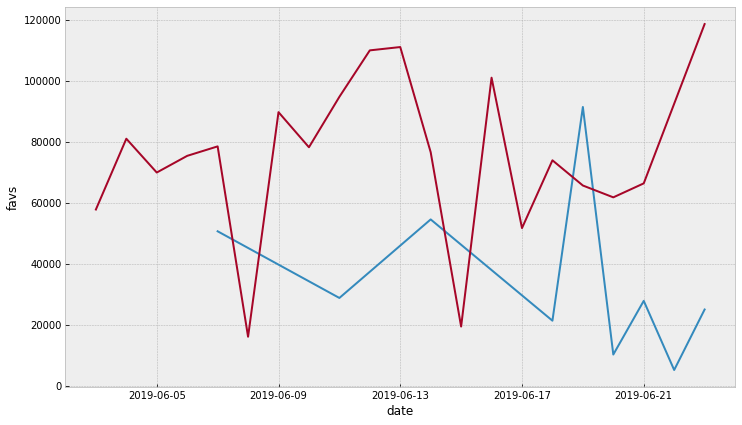

In [24]:
favs_t = favs[(favs["rate"] > 2000) & (favs["n_days"] > 20)]
len(favs)
# favs.sort_values("rate", ascending=False).head()


fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
sns.lineplot("date", "favs", "user", data=favs_t, ax=ax1)
plt.legend().remove()

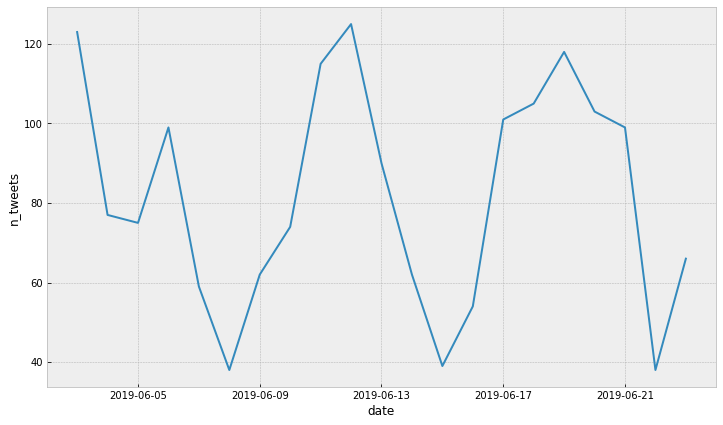

In [25]:
favs_t = favs.sort_values("n_tweets", ascending=False).groupby("date").head(1)

fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
sns.lineplot("date", "n_tweets", data=favs_t, ax=ax1)